# ! Notebook in development !

In [ ]:
1 - notebook inline
2 - pipeline 

In [1]:
import os
from pprint import pprint
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import ceci
import h5py
import yaml

Make sure to change your path in the next cell that leads to your TXPipe directory. See examples for IN2P3 and NERSC below.

In [2]:
#user specific paths -- IN2P3 example
my_txpipe_dir = "/pbs/home/m/mricci/throng_mricci/desc/TXPipe"

#user specific paths -- NERSC example
#my_txpipe_dir = "/pscratch/sd/a/avestruz/TXPipe"

os.chdir(my_txpipe_dir)

import txpipe

# let's use the pipeline approach

Here we will use the 1deg2, but we can also use the 20deg2 files (just need to change 20deg2 to 1deg2 in the name of the files)

### Launching a pipeline

Let's have a look at the submission script for this pipeline:
- to work at CCin2p3 we can use: `examples/cosmodc2/1deg2-in2p3.sub`:
- to work at NERSC we can use: `examples/cosmodc2/1deg2-nersc.sub`:

If we use the CCin2p3 example :

In [3]:
! cat examples/cosmodc2/1deg2-in2p3.sub

#!/usr/bin/bash
#SBATCH --time=01:00:00
#SBATCH --partition=hpc
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=128000

source /pbs/throng/lsst/users/jzuntz/txpipe-environments/setup-txpipe
ceci examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml


If we use the NERSC example:

In [4]:
! cat examples/cosmodc2/1deg2-nersc.sub

#!/bin/bash
#SBATCH -A m1727
#SBATCH -C cpu
#SBATCH --qos=debug
#SBATCH --time=00:30:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=32

source $CFS/lsst/groups/WL/users/zuntz/setup-txpipe
tx ceci examples/cosmodc2/pipeline-1deg2-CL-nersc.yml


This will launch a job of up to one hour (it should finish in 30 min) on a single CC-IN2P3 node to run a pipeline. After the first run, the output files are created and following runs take much less time.

In a terminal, **navigate to your TXPipe directory on IN2P3 and run**:

```
sbatch examples/cosmodc2/1deg2-in2p3.sub
```
to set it running.

If you are **on NERSC, you will instead run**:
```
sbatch examples/cosmodc2/1deg2-nersc.sub
```

Below, you will need to select the appropriate yaml file to comment/uncomment for `pipeline_file`, depending on if you are in IN2P3 or on NERSC.  

In [5]:
! cat examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml

#this step depends on where you run
#for CCin2p3
site:
    name: cc-parallel
    mpi_command: "mpirun -n"

#for NERSC
#site:
#    name: cori-batch
#    image: ghcr.io/lsstdesc/txpipe-dev


#all the following steps should not depend on where you run 
launcher:
    name: mini
    interval: 3.0
     
modules: >
    txpipe
    rail.estimation.algos.bpz_lite

python_paths: []

stages:
#    - name: TXSourceSelectorMetadetect
#      nprocess: 1
#    - name: Inform_BPZ_lite
#      nprocess: 1
#    - name: BPZ_lite
#      nprocess: 1
    - name: CLClusterBinningRedshiftRichness
      nprocess: 1
    - name: CLClusterShearCatalogs
      nprocess: 1
    - name: CLClusterEnsembleProfiles
      nprocess: 1
#    - name: CLClusterDataVector
#      nprocess: 1



output_dir: ./data/cosmodc2/outputs-1deg2-CL
config: examples/cosmodc2/config-1deg2-CL.yml

inputs:
    # See README for paths to download these files
    shear_catalog:  ./data/example/inputs/metadetect_shear_catalog.hdf5
    #photometry_cat

### Here we have 3 uncommented stages, and 5 uncommented inputs files. 
### This translate in the pipeline charts as 3 red ellipses, and 5 yellow boxes.

In [6]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-in2p3.yml"
#pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-nersc.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

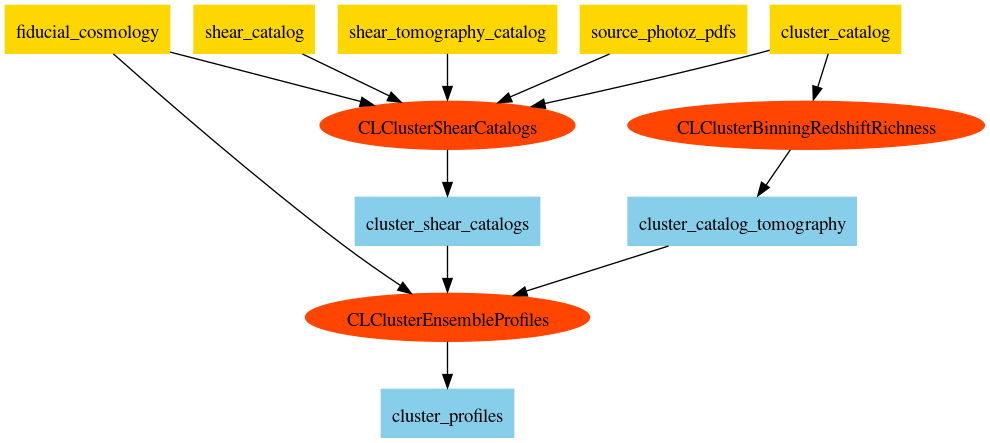

In [7]:
Image(flowchart_file)

In [13]:
print("Options for this pipeline and their defaults:")
print(txpipe.extensions.CLClusterEnsembleProfiles.config_options)

step = txpipe.extensions.CLClusterEnsembleProfiles.make_stage(
    #cluster_catalog="./data/example/inputs/cluster_catalog.hdf5",
    cluster_shear_catalogs="./data/cosmodc2/outputs-1deg2-CL/cluster_shear_catalogs.hdf5",
    fiducial_cosmology="./data/fiducial_cosmology.yml",
    cluster_catalog_tomography="./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5",
    

    # This is the output for this stage
    cluster_profiles="./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.pkl",

    # This contains all the options for this stage. You can override them here, as we do with the max_radius below.
    config="./examples/cosmodc2/config-1deg2-CL.yml",    

)



Options for this pipeline and their defaults:
{'r_min': 0.2, 'r_max': 3.0, 'nbins': 5, 'delta_sigma_profile': True, 'shear_profile': False, 'magnification_profile': False}


In [14]:
step.run()
step.finalize()

[0.3        0.53348382 0.9486833  1.68702398 3.        ]
65968 65968 65968
bin_zbin_0_richbin_0 <HDF5 group "/cluster_bin/bin_zbin_0_richbin_0" (8 members)> 5
theta_max 13.683330543251138 = 3.2290998265188118 Mpc
GCData
> defined by: cosmo='CCLCosmology(H0=71.0, Omega_dm0=0.2199999, Omega_b0=0.0448, Omega_k0=0.0)', bin_units='Mpc'
> with columns: radius_min, radius, radius_max, tangential_comp, tangential_comp_err, cross_comp, cross_comp_err, z, z_err, n_src, W_l
> 4 objects
     radius_min           radius           radius_max     ... z_err n_src  W_l 
------------------- ------------------ ------------------ ... ----- ----- -----
0.29999999999999993 0.4258387859012772 0.5334838230116767 ...   0.0    24  24.0
 0.5334838230116767 0.7490677650809866 0.9486832980505137 ...   0.0    59  59.0
 0.9486832980505137 1.3484152213058525  1.687023975571047 ...   0.0   161 161.0
  1.687023975571047 2.3924501130602525                3.0 ...   0.0   564 564.0
theta_max 12.040790270002116 = 2.6702079

In [17]:
import pickle as pkl

In [18]:
data = pkl.load(open("./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.pkl","rb"))

In [19]:
data

{'bin_zbin_0_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd2f6e30>,
 'bin_zbin_0_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd305ff0>,
 'bin_zbin_0_richbin_2': None,
 'bin_zbin_1_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd247550>,
 'bin_zbin_1_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd247ac0>,
 'bin_zbin_1_richbin_2': None,
 'bin_zbin_2_richbin_0': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd2476a0>,
 'bin_zbin_2_richbin_1': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd247430>,
 'bin_zbin_2_richbin_2': <clmm.clusterensemble.ClusterEnsemble at 0x7fe9dd247940>}

In [20]:
data['bin_zbin_0_richbin_0'].unique_id

'bin_zbin_0_richbin_0'

In [21]:
data['bin_zbin_0_richbin_0'].cov

{'tan_sc': array([[ 7.55179799e+27, -2.16679656e+27, -9.23473858e+26,
          1.36178373e+27],
        [-2.16679656e+27,  4.36680228e+27,  9.22696005e+26,
          2.54357549e+26],
        [-9.23473858e+26,  9.22696005e+26,  3.31759350e+26,
          9.09137315e+24],
        [ 1.36178373e+27,  2.54357549e+26,  9.09137315e+24,
          4.38043107e+26]]),
 'cross_sc': array([[ 1.39961394e+28, -5.86886373e+27,  5.61396136e+26,
          4.17237781e+27],
        [-5.86886373e+27,  5.81067165e+27,  1.00517522e+27,
         -1.36523715e+27],
        [ 5.61396136e+26,  1.00517522e+27,  1.16062812e+27,
          5.65919750e+26],
        [ 4.17237781e+27, -1.36523715e+27,  5.65919750e+26,
          1.50293782e+27]]),
 'tan_bs': None,
 'cross_bs': None,
 'tan_jk': None,
 'cross_jk': None}

In [22]:
len(data['bin_zbin_0_richbin_0'])

5

In [23]:
def plot_stacked_delta_sigma_profile(cl_stacked_data, title=None, ax=None):
    if ax==None:
        ax = plt.axes()

    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['tangential_comp'],'bx-',label="tan")
    ax.semilogx(cl_stacked_data.stacked_data['radius'],cl_stacked_data.stacked_data['cross_comp'],'ro-',label="cross")

    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['tangential_comp'], yerr=cl_stacked_data.cov['tan_sc'].diagonal() ** 0.5 , color='blue')
    ax.errorbar(cl_stacked_data.stacked_data['radius'], cl_stacked_data.stacked_data['cross_comp'], yerr=cl_stacked_data.cov['cross_sc'].diagonal() ** 0.5 , color='red')


    for i in range(len(cl_stacked_data)):
        ax.plot(
            cl_stacked_data.data["radius"][i],
            cl_stacked_data.data["tangential_comp"][i] ,
            "blue",
            #label="Individual",
            alpha=0.2,
            linewidth=1,
        )

    for i in range(len(cl_stacked_data)):
        ax.plot(
            cl_stacked_data.data["radius"][i],
            cl_stacked_data.data["cross_comp"][i] ,
            "red",
            #label="Individual",
            alpha=0.2,
            linewidth=1,
        )
    
    ax.legend()
    ax.set_ylabel('delta_sigma')
    ax.set_xlabel('radius')
    ax.set_title(title)


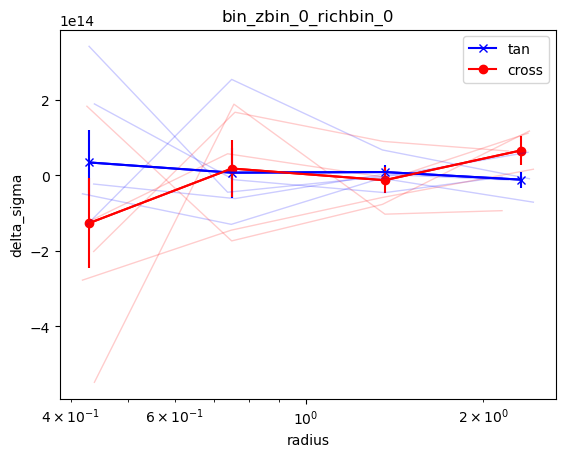

In [24]:
plot_stacked_delta_sigma_profile(data['bin_zbin_0_richbin_0'], 'bin_zbin_0_richbin_0' )


bin_zbin_0_richbin_0
bin_zbin_0_richbin_1
bin_zbin_0_richbin_2
bin_zbin_1_richbin_0
bin_zbin_1_richbin_1
bin_zbin_1_richbin_2
bin_zbin_2_richbin_0
bin_zbin_2_richbin_1
bin_zbin_2_richbin_2


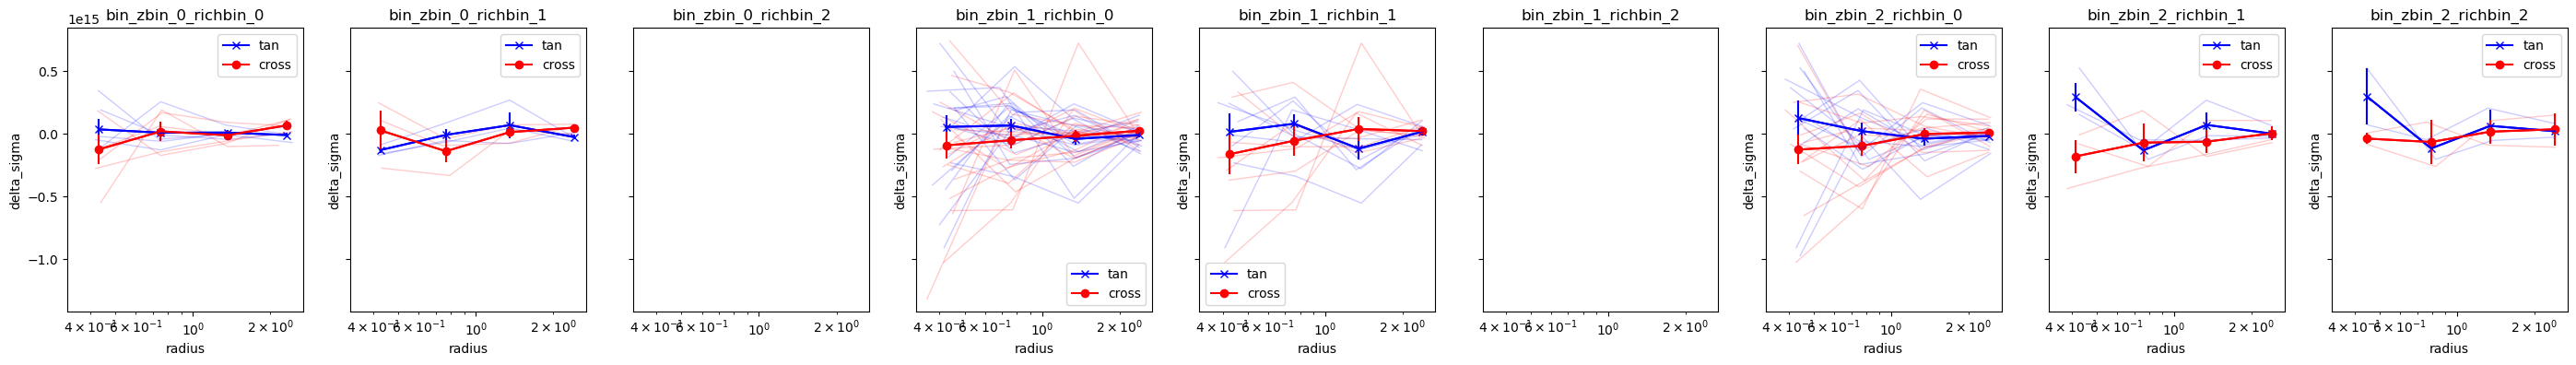

In [25]:
fig, axs = plt.subplots(1, len(data), sharex=True, sharey=True, figsize=(35, 4))
i=0
ax=axs[0]
for k in data.keys():
    print(k)
    if data[k]!=None:
        plot_stacked_delta_sigma_profile(data[k], data[k].unique_id , ax=ax)
    else :
         ax.set_title(k)
        
    i=min(i+1, len(data.keys()) - 1)
    ax=axs[0+i]


In [26]:
f = step.open_input("cluster_catalog_tomography")

print(f['cluster_bin'].keys())
print(f['cluster_bin']['bin_zbin_0_richbin_0'].keys())
print(f['cluster_bin']['bin_zbin_0_richbin_0'])
print(f['cluster_bin']['bin_zbin_0_richbin_0']['ra'][:])
    


<KeysViewHDF5 ['bin_zbin_0_richbin_0', 'bin_zbin_0_richbin_1', 'bin_zbin_0_richbin_2', 'bin_zbin_1_richbin_0', 'bin_zbin_1_richbin_1', 'bin_zbin_1_richbin_2', 'bin_zbin_2_richbin_0', 'bin_zbin_2_richbin_1', 'bin_zbin_2_richbin_2']>
<KeysViewHDF5 ['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']>
<HDF5 group "/cluster_bin/bin_zbin_0_richbin_0" (8 members)>
[60.90715206 60.74543069 60.13513592 60.65087062 60.32661051]


In [15]:
d = dict(f['provenance'].attrs)
#print(d)

<HDF5 file "cluster_catalog_tomography.hdf5" (mode r)>

In [11]:
def load_cluster_catalog_tomography(self): # TEST DON'T KNOW WHERE TO PUT THIS FUNCTION
    from astropy.table import Table
    with self.open_input("cluster_catalog_tomography") as f:
        g = f["clusters/"]
        ra = g["ra"][:]
        dec = g["dec"][:]
        redshift = g["redshift"][:]
        rich = g["richness"][:]
        ids = g["cluster_id"][:]

    return Table({"ra": ra, "dec": dec, "redshift": redshift, "richness": rich, "id": ids})

In [16]:
load_cluster_catalog_tomography()

NameError: name 'self' is not defined

In [20]:
txpipe.PipelineStage.open_input(tag="cluster_catalog_tomography") 

TypeError: PipelineStage.open_input() missing 1 required positional argument: 'self'

In [ ]:
#### TEST END

In [7]:
## Open the corresponding pipeline file to load correct input/output file names

In [8]:
with open(pipeline_file, 'r') as file:
    pipeline_content = yaml.safe_load(file)


In [48]:
## Open the corresponding config file to load config parameters

In [17]:
with open(yaml.safe_load(pipeline_content['config']), 'r') as file:
    config_content = yaml.safe_load(file)

In [18]:
config_bin_info = config_content['CLClusterBinningRedshiftRichness']

In [9]:
#open input cluster catalog
filename_in = pipeline_content['inputs']['cluster_catalog']
print(filename_in)
f_in = h5py.File(filename_in, "r")
dset_in = f_in['clusters']

./data/example/inputs/cluster_catalog.hdf5


In [10]:
#open output binning output
filename_out =pipeline_content['output_dir']+"/cluster_catalog_tomography.hdf5"
print (filename_out)
f_out = h5py.File(filename_out, "r")
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']

./data/cosmodc2/outputs-1deg2-CL/cluster_catalog_tomography.hdf5


In [11]:
[print (i, dict(dset_out[i].attrs), dset_out[i]['redshift'][:].size) for i in dset_out.keys()];

bin_zbin_0_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.4, 'z_min': 0.1} 5
bin_zbin_0_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.4, 'z_min': 0.1} 3
bin_zbin_0_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.4, 'z_min': 0.1} 0
bin_zbin_1_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.6, 'z_min': 0.4} 20
bin_zbin_1_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.6, 'z_min': 0.4} 8
bin_zbin_1_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.6, 'z_min': 0.4} 0
bin_zbin_2_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.8, 'z_min': 0.6} 13
bin_zbin_2_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.8, 'z_min': 0.6} 3
bin_zbin_2_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.8, 'z_min': 0.6} 2


In [12]:
print ([col for col in dset_out['bin_zbin_0_richbin_0']])

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


In [13]:
dict(dset_out['bin_zbin_2_richbin_2'].attrs)['rich_max']

25.0

In [14]:
dset_out['bin_zbin_'+str(0)+'_richbin_'+str(0)]['cluster_id'][:]

array([17462., 30553., 32634., 25937., 26346.])

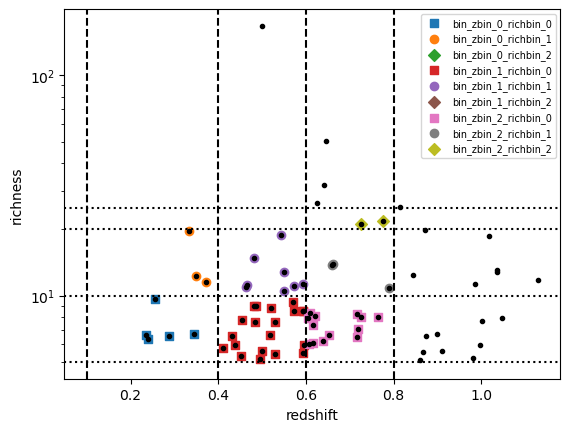

In [20]:
#plot data from input catalog
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'k.', alpha=1)
plt.xlabel('redshift')
plt.ylabel('richness')

#plot bin limits as defined in the config file
[plt.axvline(i,linestyle='dashed', color='black') for i in config_bin_info['zedge']]
[plt.axhline(i,linestyle='dotted', color='black') for i in config_bin_info['richedge']]

#overplot data from output file to make sure the bins are ordered correctly
markers=['s','o', 'D', 'P', '^']

for i in range(len(config_bin_info['zedge'])-1):
    for j in range(len(config_bin_info['richedge'])-1):
        plt.scatter(dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:], 
         dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['richness'][:], marker=markers[j], label='bin_zbin_'+str(i)+'_richbin_'+str(j))
    
    plt.legend(fontsize='x-small')

In [28]:
f_out = h5py.File("./data/cosmodc2/outputs-1deg2-CL/cluster_profiles.hdf5", "r")

In [29]:
print(f_out.keys())

<KeysViewHDF5 ['profile', 'provenance']>


In [30]:
dat_out = f_out['provenance']
dset_out = f_out['profile']

In [31]:
print(dset_out.keys())

<KeysViewHDF5 ['profile']>


In [32]:
dset_out['profile'][:]

array([(1.19713197,  8.81975682e+12, -1.85269136e+13),
       (1.64710299,  2.29355391e+13,  1.26795467e+13),
       (2.28095121,  1.68706833e+13, -1.26165595e+13),
       (3.14362613, -7.48190460e+12,  1.82552817e+12),
       (4.33987247,  9.92254335e+10, -9.90311856e+11)],
      dtype=[('radius', '<f8'), ('tangential_comp', '<f8'), ('cross_comp', '<f8')])

In [33]:
dset_out['profile']['tangential_comp']

array([ 8.81975682e+12,  2.29355391e+13,  1.68706833e+13, -7.48190460e+12,
        9.92254335e+10])

Text(0.5, 0, 'radius')

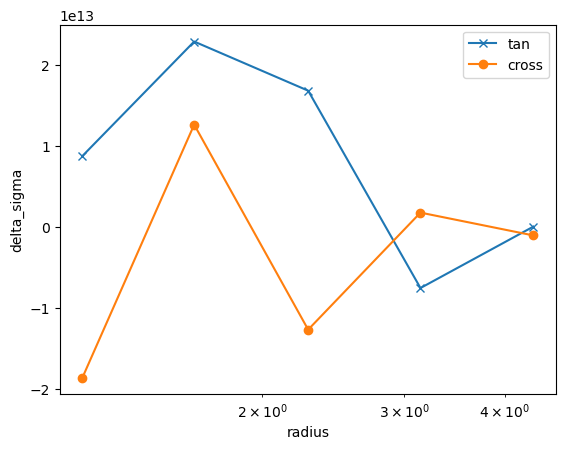

In [34]:
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['tangential_comp'],'x-',label="tan")
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['cross_comp'],'o-',label="cross")

plt.legend()
plt.ylabel('delta_sigma')
plt.xlabel('radius')

# let's do the same with 20deg2


In [37]:
! cat examples/cosmodc2/pipeline-20deg2-CL-in2p3.yml

#this step depends on where you run
#for CCin2p3
site:
    name: cc-parallel
    mpi_command: "mpirun -n"

#for NERSC
#site:
#    name: cori-batch
#    image: ghcr.io/lsstdesc/txpipe-dev


#all the following steps should not depend on where you run 
launcher:
    name: mini
    interval: 3.0
modules: >
    txpipe
    rail.estimation.algos.bpz_lite

python_paths: []

stages:
    - name: TXSourceSelectorMetadetect
      nprocess: 30
    - name: Inform_BPZ_lite
      nprocess: 1
    - name: BPZ_lite
      nprocess: 30
    - name: CLClusterBinningRedshiftRichness
      nprocess: 1
    - name: CLClusterShearCatalogs
      nprocess: 30
    - name: CLClusterEnsembleProfiles
      nprocess: 1
#    - name: CLClusterDataVector
#      nprocess: 1



output_dir: ./data/cosmodc2/outputs-20deg2-CL
config: ./examples/cosmodc2/config-20deg2-CL.yml

inputs:
    # See README for paths to download these files
    shear_catalog:  ./data/cosmodc2/20deg2/shear_catalog.hdf5
    #photometry_catalog:  ./data/c

In [39]:
# Read the appropriate pipeline configuration, and ask for a flow-chart.
pipeline_file = "examples/cosmodc2/pipeline-20deg2-CL-in2p3.yml"
#pipeline_file = "examples/cosmodc2/pipeline-1deg2-CL-nersc.yml"
flowchart_file = "CL_pipeline.png"


pipeline_config = ceci.Pipeline.build_config(
    pipeline_file,
    flow_chart=flowchart_file,
    dry_run=True
)

# Run the flow-chart pipeline
ceci.run_pipeline(pipeline_config)

0

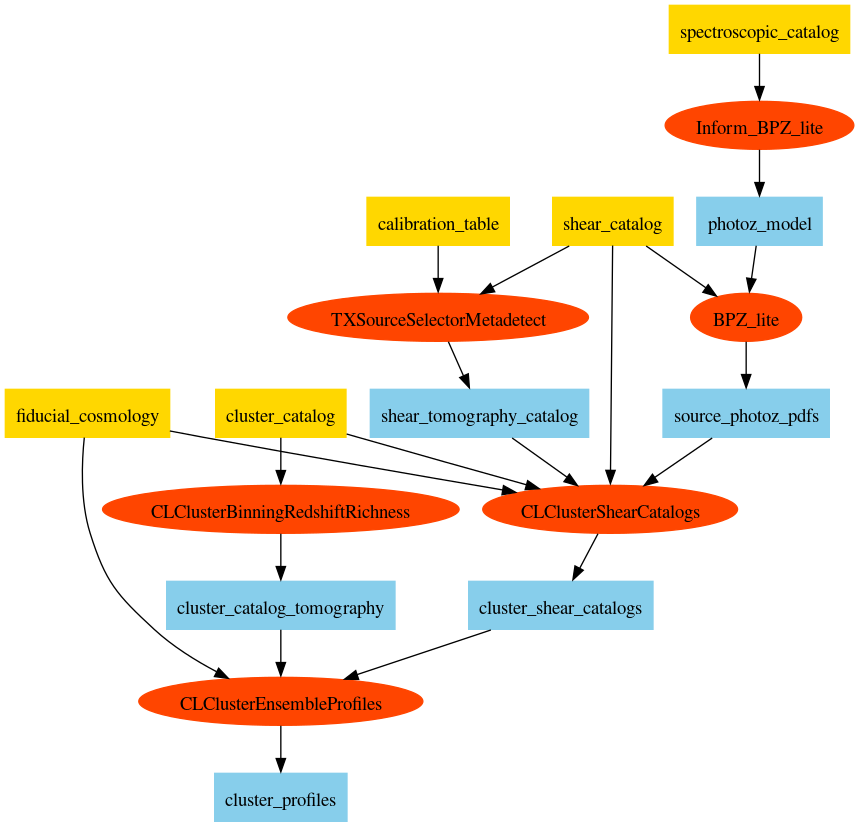

In [40]:
Image(flowchart_file)

In [7]:
## Open the corresponding pipeline file to load correct input/output file names

In [74]:
with open(pipeline_file, 'r') as file:
    pipeline_content = yaml.safe_load(file)


In [75]:
## Open the corresponding config file to load config parameters

In [76]:
with open(yaml.safe_load(pipeline_content['config']), 'r') as file:
    config_content = yaml.safe_load(file)

In [77]:
config_bin_info = config_content['CLClusterBinningRedshiftRichness']

In [78]:
#open input cluster catalog
filename_in = pipeline_content['inputs']['cluster_catalog']
print(filename_in)
f_in = h5py.File(filename_in, "r")
dset_in = f_in['clusters']

./data/cosmodc2/20deg2/cluster_catalog.hdf5


In [79]:
#open output binning output
filename_out =pipeline_content['output_dir']+"/cluster_catalog_tomography.hdf5"
print (filename_out)
f_out = h5py.File(filename_out, "r")
dat_out = f_out['provenance']
dset_out = f_out['cluster_bin']

./data/cosmodc2/outputs-20deg2-CL/cluster_catalog_tomography.hdf5


In [80]:
[print (i, dict(dset_out[i].attrs), dset_out[i]['redshift'][:].size) for i in dset_out.keys()];

bin_zbin_0_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.4, 'z_min': 0.1} 172
bin_zbin_0_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.4, 'z_min': 0.1} 44
bin_zbin_0_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.4, 'z_min': 0.1} 6
bin_zbin_1_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.6, 'z_min': 0.4} 376
bin_zbin_1_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.6, 'z_min': 0.4} 120
bin_zbin_1_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.6, 'z_min': 0.4} 14
bin_zbin_2_richbin_0 {'rich_max': 10.0, 'rich_min': 5.0, 'z_max': 0.8, 'z_min': 0.6} 293
bin_zbin_2_richbin_1 {'rich_max': 20.0, 'rich_min': 10.0, 'z_max': 0.8, 'z_min': 0.6} 83
bin_zbin_2_richbin_2 {'rich_max': 25.0, 'rich_min': 20.0, 'z_max': 0.8, 'z_min': 0.6} 8


In [81]:
print ([col for col in dset_out['bin_zbin_0_richbin_0']])

['cluster_id', 'dec', 'ra', 'redshift', 'redshift_err', 'richness', 'richness_err', 'scaleval']


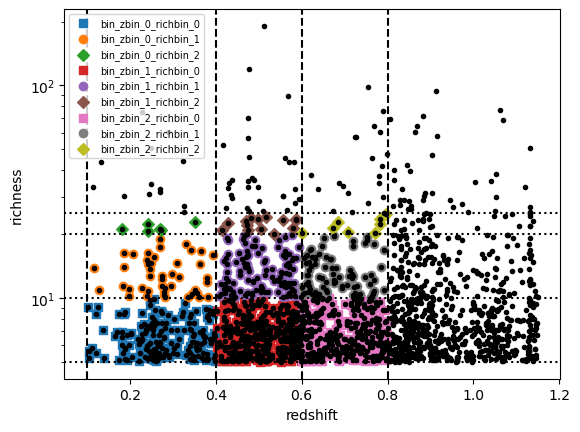

In [82]:
#plot data from input catalog
plt.semilogy(dset_in['redshift'][()], dset_in['richness'][()],'k.', alpha=1)
plt.xlabel('redshift')
plt.ylabel('richness')

#plot bin limits as defined in the config file
[plt.axvline(i,linestyle='dashed', color='black') for i in config_bin_info['zedge']]
[plt.axhline(i,linestyle='dotted', color='black') for i in config_bin_info['richedge']]

#overplot data from output file to make sure the bins are ordered correctly
markers=['s','o', 'D', 'P', '^']

for i in range(len(config_bin_info['zedge'])-1):
    for j in range(len(config_bin_info['richedge'])-1):
        plt.scatter(dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['redshift'][:], 
         dset_out['bin_zbin_'+str(i)+'_richbin_'+str(j)]['richness'][:], marker=markers[j], label='bin_zbin_'+str(i)+'_richbin_'+str(j))
    
    plt.legend(fontsize='x-small')

In [83]:
f_out = h5py.File("./data/cosmodc2/outputs-20deg2-CL/cluster_profiles.hdf5", "r")

In [84]:
print(f_out.keys())

<KeysViewHDF5 ['covariance', 'profile', 'provenance']>


In [94]:
dat_out = f_out['provenance']
dset_out = f_out['profile']
cov_out = f_out['covariance']

In [95]:
dset_out['profile'][:]

array([(1.19972624, -5.79870835e+10, -1.63092147e+12),
       (1.65500601,  5.40547408e+11, -2.53986141e+11),
       (2.28361419, -1.07945269e+11,  4.04218468e+11),
       (3.15035952,  2.99837377e+10, -3.31547551e+11),
       (4.3458853 , -2.16276791e+11, -4.26229518e+11)],
      dtype=[('radius', '<f8'), ('tangential_comp', '<f8'), ('cross_comp', '<f8')])

In [97]:
cov_out['covariance'][0]

array([[ 3.19487088e+24, -1.02886273e+23,  3.23751244e+22,
        -2.77986223e+22, -3.39920961e+22],
       [-1.02886273e+23,  1.48891072e+24, -9.82527753e+21,
         3.47507797e+22,  1.14985203e+22],
       [ 3.23751244e+22, -9.82527753e+21,  9.25161098e+23,
         2.65586051e+22,  1.57263701e+22],
       [-2.77986223e+22,  3.47507797e+22,  2.65586051e+22,
         4.78111431e+23,  9.62044028e+21],
       [-3.39920961e+22,  1.14985203e+22,  1.57263701e+22,
         9.62044028e+21,  2.92449537e+23]])

Text(0.5, 0, 'radius')

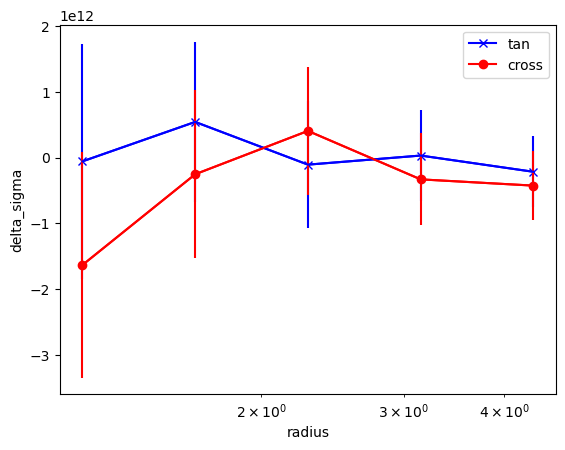

In [102]:
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['tangential_comp'],'bx-',label="tan")
plt.semilogx(dset_out['profile']['radius'],dset_out['profile']['cross_comp'],'ro-',label="cross")

plt.errorbar(dset_out['profile']['radius'], dset_out['profile']['tangential_comp'], yerr=cov_out['covariance'][0].diagonal() ** 0.5 , color='blue')
plt.errorbar(dset_out['profile']['radius'], dset_out['profile']['cross_comp'], yerr=cov_out['covariance'][1].diagonal() ** 0.5 , color='red')


plt.legend()
plt.ylabel('delta_sigma')
plt.xlabel('radius')

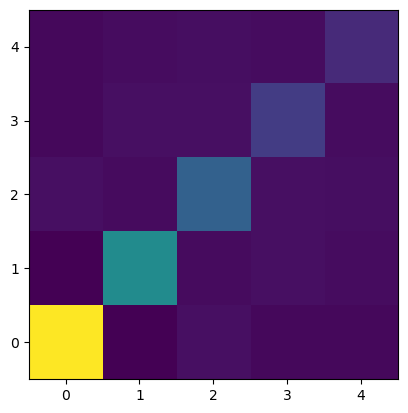

In [99]:
plt.imshow(cov_out['covariance'][0],origin='lower')